In [1]:
# define path constants
LANDING_DATA = '../data/landing/'
RAW_DATA = '../data/raw/'
CURATED_DATA = '../data/curated/'
ANALYSIS_DATA = '../data/analysis/'
PLOTS = '../plots/'

ALL_SOURCES = ('fhvhv', 'yellow', 'green')

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/08/15 21:08:04 WARN Utils: Your hostname, DESKTOP-VP2PCTV resolves to a loopback address: 127.0.1.1; using 172.21.252.215 instead (on interface eth0)
23/08/15 21:08:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/15 21:08:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from functools import reduce
from pyspark.sql import DataFrame

# combine data for all TLC sources into one dataframe
all_data = []
for source in ALL_SOURCES:
    all_data.append(spark.read.parquet(f'{CURATED_DATA}{source}'))
all_data = reduce(DataFrame.union, all_data)

In [9]:
all_data.limit(5)

pickup_datetime,dropoff_datetime,trip_distance,pickup_id,fare,trip_time,hour,month,day,source
2021-03-01 00:07:40,2021-03-01 00:31:23,16.5,138,51.0,23.72,0,3,2,yellow
2021-03-01 00:02:13,2021-03-01 00:06:01,1.13,68,5.5,3.8,0,3,2,yellow
2021-03-01 00:40:16,2021-03-01 00:50:23,2.68,239,10.5,10.12,0,3,2,yellow
2021-03-01 00:04:00,2021-03-01 00:44:20,12.4,186,40.0,40.33,0,3,2,yellow
2021-03-01 00:49:21,2021-03-01 01:06:57,9.7,132,31.0,17.6,0,3,2,yellow


In [4]:
from pyspark.sql import functions as F

# analyse total revenue over time, and share by provider
rev_data = all_data.withColumn('date', F.to_date('pickup_datetime'))
rev_data = rev_data.groupBy('date', 'source').agg(F.round(F.sum('fare'),0)).orderBy('date')
rev_data.write.mode('overwrite').parquet(ANALYSIS_DATA+'rev_data')

In [10]:
rev_data.limit(5)

date,source,"round(sum(fare), 0)"
2020-04-30,yellow,17.0
2020-05-01,yellow,149232.0
2020-05-01,green,33916.0
2020-05-01,fhvhv,3316194.0
2020-05-02,yellow,103920.0


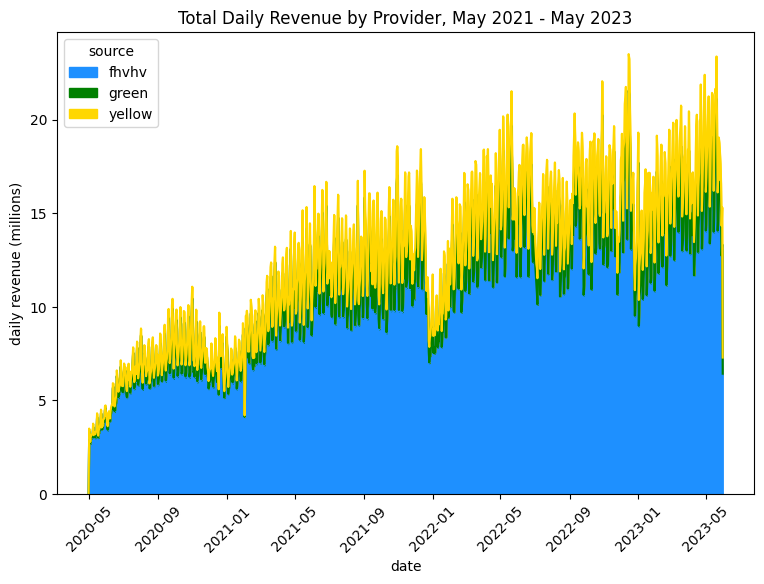

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

rev_data_pd = pd.read_parquet(ANALYSIS_DATA+'rev_data')
rev_data_pd.columns.values[2] = 'revenue'
rev_data_pd.index.names = ['Provider']
rev_data_pd = rev_data_pd.pivot(index='date', columns='source', values='revenue')
rev_data_pd = rev_data_pd/1000000
#rev_data_pd = rev_data_pd[list(ALL_SOURCES)]

plot = rev_data_pd.plot.area(
    title = 'Total Daily Revenue by Provider, May 2021 - May 2023', 
    ylabel='daily revenue (millions)',
    rot = 45, color = ['dodgerblue', 'green', 'gold'])
fig = plot.get_figure()
fig.set_size_inches(9, 6)
fig.savefig(f'{PLOTS}rev_data.jpg', dpi=100)

In [48]:

rev_data_pd = rev_data_pd[list(ALL_SOURCES)]

In [65]:
rev_data_pd.index.names = ['Provider']
rev_data_pd.head()

source,fhvhv,green,yellow
Provider,,,
2020-04-30,NaN,NaN,0.000017
2020-05-01,3.316194,0.033916,0.149232
2020-05-02,3.041748,0.023689,0.103920
2020-05-03,2.689327,0.017076,0.082521
2020-05-04,2.966292,0.033596,0.135830


In [40]:
rev_data_pd.to_csv(ANALYSIS_DATA+'rev_data_pd2.csv')